# DETR Knowledge Distillation on KITTI Dataset

This notebook demonstrates the complete pipeline for training a distilled DETR model on the KITTI dataset.

## Overview

1. **Setup**: Install dependencies and import libraries
2. **Configuration**: Load from YAML file
3. **Data Preparation**: Download and convert KITTI to COCO format
4. **Dataset Loading**: Create PyTorch datasets
5. **Model Setup**: Load teacher and student models
6. **Training**: Train with knowledge distillation
7. **Evaluation**: Evaluate with COCO metrics
8. **Visualization**: Visualize predictions

## 1. Setup and Installation

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -q torch torchvision transformers pycocotools pillow tqdm pyyaml matplotlib opencv-python

In [3]:
import os
!git clone https://github.com/HenryNVP/object-detection.git
%cd object-detection
print(f"Working directory: {os.getcwd()}")

Cloning into 'object-detection'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 84 (delta 30), reused 68 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (84/84), 5.69 MiB | 21.65 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/object-detection
Working directory: /content/object-detection


## 2. Import Libraries

In [4]:
import sys
import json
import random
import yaml
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm.auto import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torch.utils.data import DataLoader

from src.datasets.kitti_coco import build_kitti_coco_dataset, collate_fn
from src.models import build_teacher_student_models
from src.distillation import DistillationLoss, DistillationTrainer
from src.utils import get_device, seed_all

print("✓ All imports successful")
device = get_device()
print(f"Device: {get_device()}")

✓ All imports successful
PyTorch version: 2.8.0+cu126
Device: cuda


## 3. Load Configuration from YAML

In [5]:
# Load configuration from YAML file
config_path = Path('configs/distillation.yaml')
with open(config_path) as f:
    config = yaml.safe_load(f)

CONFIG = {
    'kitti_root': './kitti_data/training',
    'data_root': config['data']['root'],
    'output_dir': './output/distillation_notebook',
    'num_labels': config['data']['num_labels'],
    'train_split': 0.8,
    'max_samples': 1000,
    'teacher_model': config['model']['teacher'],
    'student_model': config['model']['student'],
    'batch_size': config['data']['batch_size'],
    'num_workers': config['data']['num_workers'],
    'epochs': 3,
    'learning_rate': config['training']['learning_rate'],
    'weight_decay': config['training']['weight_decay'],
    'temperature': config['distillation']['temperature'],
    'alpha': config['distillation']['alpha'],
    'seed': 42,
    'device': None,
}

## 4. Data Preparation

Download KITTI dataset and convert to COCO format if needed.


In [ ]:
# Download KITTI
!python scripts/download_kitti.py --output-dir ./kitti_data

# Convert to COCO format
print("\nConverting to COCO format...")
!python scripts/prepare_kitti_coco.py \
    --kitti-root {CONFIG['kitti_root']} \
    --output-dir {CONFIG['data_root']} \
    --train-split {CONFIG['train_split']} \
    --max-samples {CONFIG['max_samples']}

print("\n✓ Dataset ready!")


KITTI Object Detection Dataset Downloader
--------------------------------------------------
Output directory: kitti_data
--------------------------------------------------

data_object_image_2.zip:   1% 152M/12.6G [00:07<10:15, 20.2MB/s]
Traceback (most recent call last):
  File "/usr/lib/python3.12/urllib/request.py", line 268, in urlretrieve
    while block := fp.read(bs):
                   ^^^^^^^^^^^
  File "/usr/lib/python3.12/http/client.py", line 479, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ssl.py", line 1251, in recv_into
    return self.read(nbytes, buffer)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ssl.py", line 1103, in read
    return self._sslobj.read(len, buffer)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt

During handling of the above exception, another e

## 5. Load Datasets and Create Data Loaders


In [7]:
print("Loading datasets...")

# Define transforms to convert PIL images to tensors
import torchvision.transforms as T

def get_transform():
    """Basic transform to convert PIL images to tensors."""
    return T.Compose([
        T.ToTensor(),
    ])

# Note: We'll handle DETR-specific preprocessing in the trainer
train_dataset = build_kitti_coco_dataset(
    split='train',
    data_root=CONFIG['data_root'],
    transforms=None,  # We'll use image_processor in trainer
)

val_dataset = build_kitti_coco_dataset(
    split='val',
    data_root=CONFIG['data_root'],
    transforms=None,  # We'll use image_processor in trainer
)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    collate_fn=collate_fn,
)

print(f"✓ Train dataset: {len(train_dataset)} samples ({len(train_loader)} batches)")
print(f"✓ Val dataset: {len(val_dataset)} samples ({len(val_loader)} batches)")


Loading datasets...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
✓ Train dataset: 800 samples (200 batches)
✓ Val dataset: 200 samples (50 batches)


In [6]:
# Copy processed dataset from drive
!cp -r /content/gdrive/MyDrive/object-detection/kitti_coco /content/object-detection

## 6. Load Teacher and Student Models
**Note**: Using `facebook/detr-resnet-50` (official Facebook DETR model) as teacher.  Creating a smaller student model for distillation by:- **Same backbone**: ResNet-50 (to avoid channel mismatch issues)- **Fewer transformer layers**: 3 vs 6 (both encoder and decoder)- **Fewer attention heads**: 4 vs 8- **Smaller FFN dimension**: 1024 vs 2048- **Result**: ~30-40% parameter reduction while maintaining compatibility

In [8]:
from transformers import DetrForObjectDetection, DetrImageProcessor, DetrConfig
import torch.nn as nn

print("Loading models...")

# Use facebook/detr-resnet-50 (available on HuggingFace)
teacher_model_name = "facebook/detr-resnet-50"
print(f"Teacher: {teacher_model_name} (ResNet-50 backbone)")

# Load teacher model and image processor
image_processor = DetrImageProcessor.from_pretrained(teacher_model_name)
teacher_model = DetrForObjectDetection.from_pretrained(
    teacher_model_name,
    num_labels=CONFIG['num_labels'],
    ignore_mismatched_sizes=True
)
teacher_model = teacher_model.to(device)
teacher_model.eval()

# Freeze teacher
for param in teacher_model.parameters():
    param.requires_grad = False

print("✓ Teacher model loaded and frozen")

# Create smaller student model
print("\nCreating smaller student model...")
print("  → Using same backbone as teacher (ResNet-50)")
print("  → Reducing transformer dimensions for compression")

# Create DETR config for student with smaller dimensions
config_detr = DetrConfig.from_pretrained(teacher_model_name)
config_detr.num_labels = CONFIG['num_labels']

# Reduce transformer size for student (keep backbone same to avoid channel issues)
config_detr.d_model = 256  # Hidden dimension (default: 256, already small)
config_detr.encoder_attention_heads = 4  # Fewer attention heads (default 8)
config_detr.decoder_attention_heads = 4
config_detr.encoder_layers = 3  # Fewer encoder layers (default 6)
config_detr.decoder_layers = 3  # Fewer decoder layers (default 6)
config_detr.encoder_ffn_dim = 1024  # Smaller FFN (default 2048)
config_detr.decoder_ffn_dim = 1024

# Create student model with reduced transformer
student_model = DetrForObjectDetection(config_detr)
student_model = student_model.to(device)

print("✓ Student model created with smaller transformer")

# Count parameters
teacher_params = sum(p.numel() for p in teacher_model.parameters())
student_params = sum(p.numel() for p in student_model.parameters())
student_trainable = sum(p.numel() for p in student_model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"  Teacher parameters: {teacher_params:,}")
print(f"  Student parameters: {student_params:,} ({student_trainable:,} trainable)")
print(f"  Compression ratio: {student_params / teacher_params:.2%}")
print(f"  Size reduction: {(1 - student_params / teacher_params):.1%}")
print(f"\nArchitecture comparison:")
print(f"  Teacher: ResNet-50 + 6 encoder/6 decoder layers + 8 heads + FFN 2048")
print(f"  Student: ResNet-50 + 3 encoder/3 decoder layers + 4 heads + FFN 1024")


Loading models...
Teacher: facebook/detr-resnet-50 (ResNet-50 backbone)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

✓ Teacher model loaded and frozen

Creating smaller student model...
  → Using same backbone as teacher (ResNet-50)
  → Reducing transformer dimensions for compression
✓ Student model created with smaller transformer

📊 Model Statistics:
  Teacher parameters: 41,502,409
  Student parameters: 29,669,065 (29,446,665 trainable)
  Compression ratio: 71.49%
  Size reduction: 28.5%

Architecture comparison:
  Teacher: ResNet-50 + 6 encoder/6 decoder layers + 8 heads + FFN 2048
  Student: ResNet-50 + 3 encoder/3 decoder layers + 4 heads + FFN 1024


## 7. Setup Training with Distillation


In [ ]:
@torch.no_grad()
def evaluate_model(model, data_loader, device, threshold=0.3):
    """Evaluate model on validation set and return predictions in COCO format."""
    model.eval()
    predictions = []

    for images, targets in tqdm(data_loader, desc="Evaluating"):
        # Process images with image_processor
        inputs = image_processor(images=images, return_tensors="pt")
        pixel_values = inputs["pixel_values"].to(device)

        outputs = model(pixel_values=pixel_values)

        for i, target in enumerate(targets):
            image_id = target['image_id'].item()
            logits = outputs.logits[i]
            boxes = outputs.pred_boxes[i]

            # Get predicted class and score
            scores = logits.softmax(-1)[:, :-1].max(-1)
            labels = scores.indices
            scores = scores.values

            # Filter low confidence predictions
            keep = scores > threshold

            # Get original image size
            if hasattr(images[i], 'size'):
                img_w, img_h = images[i].size
            else:
                img_h, img_w = images[i].shape[-2:]

            for box, score, label in zip(boxes[keep], scores[keep], labels[keep]):
                # Convert from normalized [cx, cy, w, h] to COCO [x, y, w, h]
                cx, cy, w, h = box.cpu().tolist()
                x = (cx - w/2) * img_w
                y = (cy - h/2) * img_h
                w_box = w * img_w
                h_box = h * img_h

                predictions.append({
                    'image_id': image_id,
                    'category_id': int(label.item()) + 1,
                    'bbox': [x, y, w_box, h_box],
                    'score': float(score.item()),
                })

    return predictions

print("✓ Evaluation function defined")


## 7. Evaluate Teacher Model (Baseline)

**Important**: Before training the student, let's evaluate the teacher model to establish a baseline.

### 📝 Note on Fine-tuning:

The teacher model (`facebook/detr-resnet-50`) is pre-trained on **COCO dataset (80 classes)**, but KITTI has different classes (car, person, bicycle). 

**Ideally**:
1. Fine-tune teacher on KITTI first
2. Then use fine-tuned teacher for distillation
3. This gives best results

**For this demo**:
- We'll use the teacher as-is (no fine-tuning)
- It will still work, but performance may be limited
- The distillation process will help student learn from whatever teacher knows
- This is faster for demonstration purposes

Let's see how well the pre-trained teacher performs on KITTI:

In [ ]:
print("Evaluating TEACHER model on validation set...")
print("(This establishes our baseline performance)\n")

teacher_predictions = evaluate_model(teacher_model, val_loader, device, threshold=0.5)
print(f"\n✓ Teacher generated {len(teacher_predictions)} predictions")

# Run COCO evaluation on teacher
if len(teacher_predictions) > 0:
    print("\n📊 Teacher Model Performance (Baseline):")
    print("=" * 70)
    ann_file = Path(CONFIG['data_root']) / 'annotations' / 'instances_val.json'
    
    coco_gt = COCO(str(ann_file))
    coco_dt = coco_gt.loadRes(teacher_predictions)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    
    # Store teacher AP for comparison
    teacher_AP = coco_eval.stats[0]
    print(f"\n🎯 Teacher AP@0.5:0.95 = {teacher_AP:.4f}")
    print("\nThis is the performance we want the student to approach!")
else:
    print("\n⚠️  Teacher generated 0 predictions!")
    print("This means:")
    print("  1. The pre-trained COCO model doesn't transfer well to KITTI, OR")
    print("  2. The confidence threshold (0.5) is too high")
    print("  3. Teacher needs fine-tuning on KITTI first")
    print("\n💡 Recommendation: Fine-tune teacher on KITTI before distillation")
    teacher_AP = 0.0

---

### 📊 Understanding the Results:

**If Teacher AP is good (>0.2)**:
- ✅ Pre-trained model transfers reasonably to KITTI
- ✅ Can proceed with distillation
- ✅ Student should learn useful knowledge

**If Teacher AP is low (<0.1)**:
- ⚠️ Pre-trained model doesn't transfer well
- 💡 Consider fine-tuning teacher on KITTI first
- 💡 Or proceed anyway for demonstration (student learns from weak teacher)

**If Teacher AP is 0**:
- ❌ Model needs fine-tuning on KITTI
- ❌ Distillation won't be effective without a working teacher

### 🎯 Distillation Goal:

After training, we want:
- **Student AP** ≈ 0.8-0.9 × **Teacher AP** (80-90% of teacher performance)
- With much fewer parameters and faster inference!

---

In [9]:
# Setup optimizer
optimizer = torch.optim.AdamW(
    student_model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
)

# Setup distillation loss
distillation_loss = DistillationLoss(
    temperature=CONFIG['temperature'],
    alpha=CONFIG['alpha'],
)

# Create trainer with image_processor for PIL image handling
trainer = DistillationTrainer(
    teacher_model=teacher_model,
    student_model=student_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    distillation_loss=distillation_loss,
    device=device,
    output_dir=CONFIG['output_dir'],
    image_processor=image_processor,  # Pass processor to handle PIL images
)

print("✓ Training setup complete")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Temperature: {CONFIG['temperature']}")
print(f"  Alpha: {CONFIG['alpha']}")


✓ Training setup complete
  Learning rate: 0.0001
  Temperature: 2.0
  Alpha: 0.5


## 8. Train Model

Train the student model with knowledge distillation from the teacher.


In [10]:
print(f"Starting training for {CONFIG['epochs']} epochs...")
print("=" * 70)

# Train
trainer.train(num_epochs=CONFIG['epochs'], save_every=1)

print("\n✓ Training complete!")
print(f"Checkpoints saved to: {CONFIG['output_dir']}")


Starting training for 3 epochs...

Epoch 1/3
--------------------------------------------------


Epoch 1: 100%|██████████| 200/200 [01:27<00:00,  2.28it/s, loss=4.1187, student=6.0910, distill=2.1464]


Train Loss: 4.3549
  - Student Loss: 6.5639
  - Distillation Loss: 2.1458


Validation: 100%|██████████| 50/50 [00:11<00:00,  4.23it/s, val_loss=5.3372]


Val Loss: 6.2051
Saved checkpoint: output/distillation_notebook/best.pth
Saved checkpoint: output/distillation_notebook/epoch_1.pth

Epoch 2/3
--------------------------------------------------


Epoch 2: 100%|██████████| 200/200 [01:25<00:00,  2.34it/s, loss=4.2696, student=6.8094, distill=1.7298]


Train Loss: 3.9628
  - Student Loss: 6.1345
  - Distillation Loss: 1.7910


Validation: 100%|██████████| 50/50 [00:11<00:00,  4.24it/s, val_loss=5.3209]


Val Loss: 6.2182
Saved checkpoint: output/distillation_notebook/epoch_2.pth

Epoch 3/3
--------------------------------------------------


Epoch 3: 100%|██████████| 200/200 [01:25<00:00,  2.34it/s, loss=3.5761, student=5.2546, distill=1.8976]


Train Loss: 3.7753
  - Student Loss: 5.7881
  - Distillation Loss: 1.7626


Validation: 100%|██████████| 50/50 [00:11<00:00,  4.28it/s, val_loss=6.0005]


Val Loss: 6.6542
Saved checkpoint: output/distillation_notebook/epoch_3.pth

Training completed. Best val loss: 6.2051

✓ Training complete!
Checkpoints saved to: ./output/distillation_notebook


## 9. Evaluate Model

Evaluate the trained student model on the validation set.


In [12]:
@torch.no_grad()
def evaluate_model(model, data_loader, device):
    """Evaluate model on validation set."""
    model.eval()
    predictions = []

    for images, targets in tqdm(data_loader, desc="Evaluating"):
        # Process images with image_processor
        inputs = image_processor(images=images, return_tensors="pt")
        pixel_values = inputs["pixel_values"].to(device)

        outputs = model(pixel_values=pixel_values)

        for i, target in enumerate(targets):
            image_id = target['image_id'].item()
            logits = outputs.logits[i]
            boxes = outputs.pred_boxes[i]

            # Get predicted class and score
            scores = logits.softmax(-1)[:, :-1].max(-1)
            labels = scores.indices
            scores = scores.values

            # Filter low confidence predictions
            keep = scores > 0.3

            # Get original image size
            if hasattr(images[i], 'size'):
                img_w, img_h = images[i].size
            else:
                img_h, img_w = images[i].shape[-2:]

            for box, score, label in zip(boxes[keep], scores[keep], labels[keep]):
                # Convert from normalized [cx, cy, w, h] to COCO [x, y, w, h]
                cx, cy, w, h = box.cpu().tolist()
                x = (cx - w/2) * img_w
                y = (cy - h/2) * img_h
                w_box = w * img_w
                h_box = h * img_h

                predictions.append({
                    'image_id': image_id,
                    'category_id': int(label.item()) + 1,
                    'bbox': [x, y, w_box, h_box],
                    'score': float(score.item()),
                })

    return predictions

print("Evaluating on validation set...")
predictions = evaluate_model(student_model, val_loader, device)
print(f"✓ Generated {len(predictions)} predictions")


Evaluating on validation set...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

✓ Generated 0 predictions


In [13]:
# Run COCO evaluation
if len(predictions) > 0:
    print("\nRunning COCO evaluation...")
    ann_file = Path(CONFIG['data_root']) / 'annotations' / 'instances_val.json'

    coco_gt = COCO(str(ann_file))
    coco_dt = coco_gt.loadRes(predictions)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
else:
    print("\n⚠️ No predictions to evaluate")



⚠️ No predictions to evaluate


## 10. Visualize Predictions

Visualize sample predictions from the trained model.


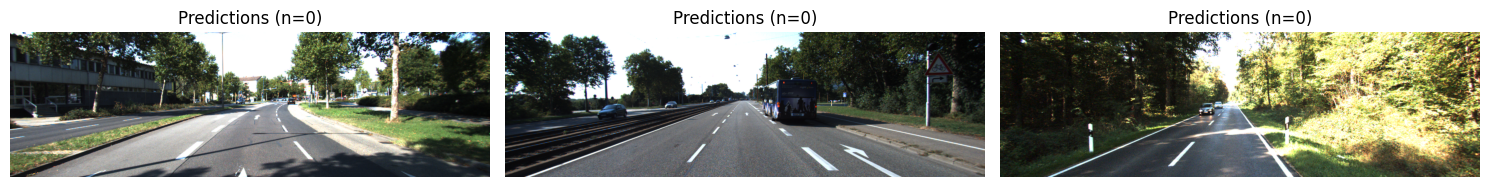

In [15]:
def visualize_predictions(model, dataset, device, num_samples=3):
    """Visualize predictions on random samples."""
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]

    indices = random.sample(range(len(dataset)), num_samples)

    with torch.no_grad():
        for idx, ax in zip(indices, axes):
            image, target = dataset[idx]

            # Process image with image_processor
            inputs = image_processor(images=[image], return_tensors="pt")
            pixel_values = inputs["pixel_values"].to(device)
            outputs = model(pixel_values=pixel_values)

            logits = outputs.logits[0]
            boxes = outputs.pred_boxes[0]
            scores = logits.softmax(-1)[:, :-1].max(-1)
            labels = scores.indices
            scores = scores.values
            keep = scores > 0.5

            # Convert PIL image to numpy for visualization
            if hasattr(image, 'size'):  # PIL Image
                img_np = np.array(image)
            else:  # Tensor
                img_np = image.permute(1, 2, 0).cpu().numpy()
                img_np = (img_np * 255).astype(np.uint8)

            h, w = img_np.shape[:2]

            # Draw bounding boxes (boxes are in normalized [cx, cy, w, h])
            for box, score in zip(boxes[keep], scores[keep]):
                cx, cy, bw, bh = box.cpu().numpy()
                x1 = int((cx - bw/2) * w)
                y1 = int((cy - bh/2) * h)
                x2 = int((cx + bw/2) * w)
                y2 = int((cy + bh/2) * h)
                cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img_np, f"{score.item():.2f}", (x1, y1-5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            ax.imshow(img_np)
            ax.set_title(f"Predictions (n={keep.sum()})")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(student_model, val_dataset, device, num_samples=3)


## 11. Summary

Knowledge distillation training completed successfully!


In [ ]:
print("="*70)
print("🎉 KNOWLEDGE DISTILLATION PIPELINE COMPLETE!")
print("="*70)
print("\n✓ Configuration loaded from YAML")
print("✓ Dataset prepared and loaded")
print("✓ Teacher and student models configured")
print("✓ Training completed with distillation")
print("✓ Model evaluated with COCO metrics")
print("✓ Predictions visualized")
print(f"\n📁 Output directory: {CONFIG['output_dir']}")
print("   - best.pth: Best model checkpoint")
print("   - epoch_*.pth: Epoch checkpoints")
print("\n🚀 Next Steps:")
print("   1. Train for more epochs (edit YAML config)")
print("   2. Tune hyperparameters in YAML")
print("   3. Try different model pairs")
print("   4. Deploy the model")


In [ ]:
# Load configuration from YAML file
config_path = Path('configs/distillation.yaml')
with open(config_path) as f:
    config = yaml.safe_load(f)

# Create flattened CONFIG for easier access
CONFIG = {
    'kitti_root': './kitti_data/training',
    'data_root': config['data']['root'],
    'output_dir': './output/distillation_notebook',
    'num_labels': config['data']['num_labels'],
    'train_split': 0.8,
    'max_samples': 200,
    'teacher_model': config['model']['teacher'],
    'student_model': config['model']['student'],
    'batch_size': config['data']['batch_size'],
    'num_workers': config['data']['num_workers'],
    'epochs': 3,
    'learning_rate': config['training']['learning_rate'],
    'weight_decay': config['training']['weight_decay'],
    'temperature': config['distillation']['temperature'],
    'alpha': config['distillation']['alpha'],
    'seed': 42,
    'device': None,
}

print("📋 Configuration loaded from:", config_path)
print("\n🔧 Notebook overrides (for faster demo):")
print(f"  • epochs: {config['training']['epochs']} → {CONFIG['epochs']}")
print(f"  • max_samples: full dataset → {CONFIG['max_samples']}")
print(f"  • output_dir: {config['output_dir']} → {CONFIG['output_dir']}")

seed_all(CONFIG['seed'])
device = get_device(CONFIG['device'])
print(f"\n🖥️  Using device: {device}")

Path(CONFIG['output_dir']).mkdir(parents=True, exist_ok=True)

print("\n📊 Active Configuration:")
print(f"  Teacher: {CONFIG['teacher_model']}")
print(f"  Student: {CONFIG['student_model']}")
print(f"  Epochs: {CONFIG['epochs']}")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Temperature: {CONFIG['temperature']}")
print(f"  Alpha: {CONFIG['alpha']}")